# 8 Deep Learning with Keras

## 8.3 Custom Datasets

#### Cats and Dogs Dataset

Download the dataset:
`https://drive.google.com/file/d/1U6RtBhML-Lj0w2suve0UhQmwcF5pfJCm/view`

**Datasets for classification should have this folder structure for Keras**:
```bash
train/
    class_1/
        file_1.jpg
        file_2.jpg
        ...
    class_2/
    ...
    class_n/
test/
    class_1/
    class_2/
    ...
    class_n/
```

In [1]:
import matplotlib.pyplot as plt
import cv2
%matplotlib inline

In [7]:
path = '../../data/'
img = cv2.imread(path+'CATS_DOGS/train/CAT/0.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

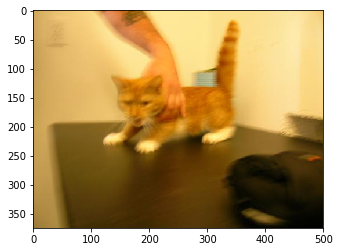

In [8]:
plt.imshow(img)

In [9]:
img.shape

(375, 500, 3)

In [10]:
img = cv2.imread(path+'CATS_DOGS/train/DOG/2.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

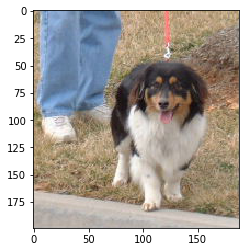

In [11]:
plt.imshow(img)

In [12]:
img.shape

(199, 188, 3)

In [15]:
img.max()

255

**IMPORTANT NOTE**: all files have a different shape; we need to standardize them!

In [13]:
# Data augmentation: for more robust and generalizable trainings
from keras.preprocessing.image import ImageDataGenerator

In [16]:
# We pass max absolute values of ranges for data augmentation
# rotation: degrees by which image can be rotated
# width, height shift: % that the image width/height can be changed
# rescale: normalization = divide by max pixel value
# shear: % by which image can be stretched from the diagonal
# zoom: % of image augmenation
# horizontal flip: flip also images?
# fill mode: when pixels are created/removed (eg., when rotating), which values do we take?
image_gen = ImageDataGenerator(rotation_range=30,
                              width_shift_range=0.1,
                              height_shift_range=0.1,
                              rescale=1/255,
                              shear_range=0.2,
                              zoom_range=0.2,
                              horizontal_flip=True,
                              fill_mode='nearest')

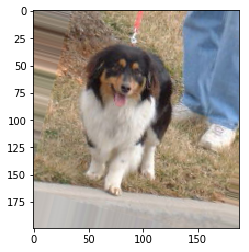

In [22]:
# We can apply this augmentation transform image-wise easily!
# Every time we call it, we have a slighthly different transformed image
plt.imshow(image_gen.random_transform(img))

In [64]:
# We define the input shape
# All images are going to be resized to that shape
input_shape = (150, 150, 3)

In [24]:
# In order to apply data augmentation, we create an iterator on the dataset (for both train & test)
# IMPORTANT NOTE: we need to have the aforementioned structure within each train/test folder: one folder per class
image_gen.flow_from_directory(path+'CATS_DOGS/train')

Found 18743 images belonging to 2 classes.


In [25]:
image_gen.flow_from_directory(path+'CATS_DOGS/test')

Found 6251 images belonging to 2 classes.


#### Build Model & Train

Note: In the newsest versions there hasbeen an update in the API sysntax, eg., `MaxPooling2D` instead of `MaxPool2D`.

In [48]:
from keras.models import Sequential

In [49]:
from keras.layers import Activation, Dropout, Flatten, Conv2D, Dense, MaxPooling2D

In [50]:
model = Sequential()

# Convolution + Max-Pooling 1
model.add(Conv2D(filters=32, kernel_size=(3,3), input_shape=input_shape, activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

# Convolution + Max-Pooling 2 (once more, because images are quite complex)
model.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

# Convolution + Max-Pooling 3 (once more, because images are quite complex)
model.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())

model.add(Dense(128))
model.add(Activation('relu')) # that's a new feature: we can add activaton separately!

model.add(Dropout(0.5)) # Dropout layer: 50% of neurons shut down randomly

model.add(Dense(1)) # Binary: Cat / Dog?
model.add(Activation('softmax'))

model.compile(loss='binary_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

In [51]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 72, 72, 32)        9248      
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 34, 34, 32)        9248      
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 17, 17, 32)        0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 9248)              0         
__________

In [52]:
# We define also a batch size
# Images are going to be delivered in batches
# A standard size is 16
batch_size = 16

In [53]:
train_image_gen = image_gen.flow_from_directory(path+'CATS_DOGS/train',
                                               target_size=input_shape[:2],
                                               batch_size=batch_size,
                                               class_mode='binary')

Found 18743 images belonging to 2 classes.


In [54]:
test_image_gen = image_gen.flow_from_directory(path+'CATS_DOGS/test',
                                               target_size=input_shape[:2],
                                               batch_size=batch_size,
                                               class_mode='binary')

Found 6251 images belonging to 2 classes.


In [55]:
# We can get class/category names from folder names
train_image_gen.class_indices

{'CAT': 0, 'DOG': 1}

In [ ]:
# TRAIN
# usually an epoch is a complete pass of all training images
# if we define steps_per_epoch, then,
# epoch: steps_per_epoch x batch_size images, not all of them
# We can also pass the validation/test split here to check/prevent overfitting
# Very low values are used here to get a fast training; if done seriously, use higher commented values
results = model.fit_generator(train_image_gen,
                    epochs=1, # 150
                    steps_per_epoch=1, # 1000
                    validation_data=test_image_gen,
                    validation_steps=1) # 300

We can get warning during training because some images cannot be opened/read (eg., because they are corrupt). We can just ignore them. Optionally, we can add these lines:

```python
import warnings
warnings.filterwarnings('ignore')
```

In [ ]:
# We can get the evolution of the accuracy during training and plot it!
results.history['acc']

In [ ]:
plt.plot(results.history['acc'])

#### Inference

Usually, we need to train our model with a considerable amount of epochs. Therefore, I load a pre-trained model.

In [77]:
from keras.models import load_model

In [78]:
new_model = load_model('cat_dog_100epochs.h5')

In [79]:
img = path + 'CATS_DOGS/test/DOG/10005.jpg'

We need to resize it to the target size!

In [80]:
from keras.preprocessing import image

In [81]:
# We can load the image and resize it automatically
# BUT: the image is not a numpy array, so it must be converted
img = image.load_img(img, target_size=input_shape[:2])

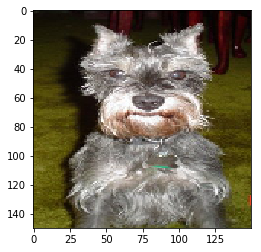

In [82]:
plt.imshow(img)

In [86]:
# We need to convert it to a numpy array manually
img = image.img_to_array(img)

In [85]:
img.shape

(150, 150, 3)

In [87]:
# And we need to give the image the shape (Sample, W, H, C) = (1, W, H, C) = (1, 150, 150, 3)
import numpy as np
img = np.expand_dims(img, axis=0)

In [88]:
img.shape

(1, 150, 150, 3)

In [100]:
# Class 0/1 inferred
result = model.predict_classes(img)

In [101]:
result

array([[1]], dtype=int32)

In [102]:
train_image_gen.class_indices

{'CAT': 0, 'DOG': 1}

In [103]:
# Raw probability should be predicted
result = model.predict(img)

In [104]:
result

array([[1.]], dtype=float32)